## Image segmentation with CamVid

In [ ]:
%matplotlib inline

In [ ]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from nbdev.showdoc import *

In [ ]:
path = untar_data(URLs.CAMVID)
path.ls()

(#4) [Path('/home/sgugger/.fastai/data/camvid/codes.txt'),Path('/home/sgugger/.fastai/data/camvid/labels'),Path('/home/sgugger/.fastai/data/camvid/valid.txt'),Path('/home/sgugger/.fastai/data/camvid/images')]

In [ ]:
path_lbl = path/'labels'
path_img = path/'images'

## Data

In [ ]:
fnames = get_image_files(path_img)
fnames[:3]

(#3) [Path('/home/sgugger/.fastai/data/camvid/images/Seq05VD_f02130.png'),Path('/home/sgugger/.fastai/data/camvid/images/0016E5_05310.png'),Path('/home/sgugger/.fastai/data/camvid/images/0016E5_07230.png')]

In [ ]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

(#3) [Path('/home/sgugger/.fastai/data/camvid/labels/Seq05VD_f03780_P.png'),Path('/home/sgugger/.fastai/data/camvid/labels/0016E5_00840_P.png'),Path('/home/sgugger/.fastai/data/camvid/labels/0016E5_07997_P.png')]

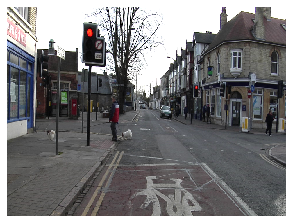

In [ ]:
img_f = fnames[0]
img = PILImage.create(img_f)
img.show(figsize=(5,5))

In [ ]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

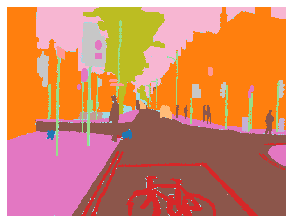

In [ ]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [ ]:
src_size = np.array(mask.shape[1:])
src_size,tensor(mask)

(array([960]), tensor([[ 4,  4,  4,  ..., 21, 21, 21],
         [ 4,  4,  4,  ..., 21, 21, 21],
         [ 4,  4,  4,  ..., 21, 21, 21],
         ...,
         [19, 19, 19,  ..., 17, 17, 17],
         [30, 19, 19,  ..., 17, 17, 17],
         [30, 30, 30,  ..., 17, 17, 17]], dtype=torch.uint8))

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [ ]:
size = src_size//2
bs=8

In [ ]:
valid_fnames = (path/'valid.txt').read().split('\n')

In [ ]:
# export
def FileSplitter(fname):
    "Split `items` depending on the value of `mask`."
    valid = Path(fname).read().split('\n') 
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner

In [ ]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=FileSplitter(path/'valid.txt'),
                   get_y=lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
                   batch_tfms=[*aug_transforms(size=(360,480)), Normalize.from_stats(*imagenet_stats)])

In [ ]:
dls = camvid.dataloaders(path/"images", bs=8, path=path)

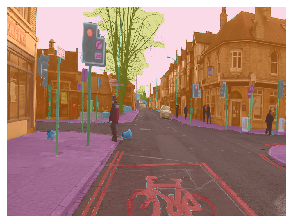

In [ ]:
show_at(dls.train_ds, 0)

In [ ]:
b = dls.train.one_batch()

In [ ]:
b = dls.train.decode(b)

In [ ]:
b[0].shape, b[1].shape

(torch.Size([8, 3, 360, 480]), torch.Size([8, 360, 480]))

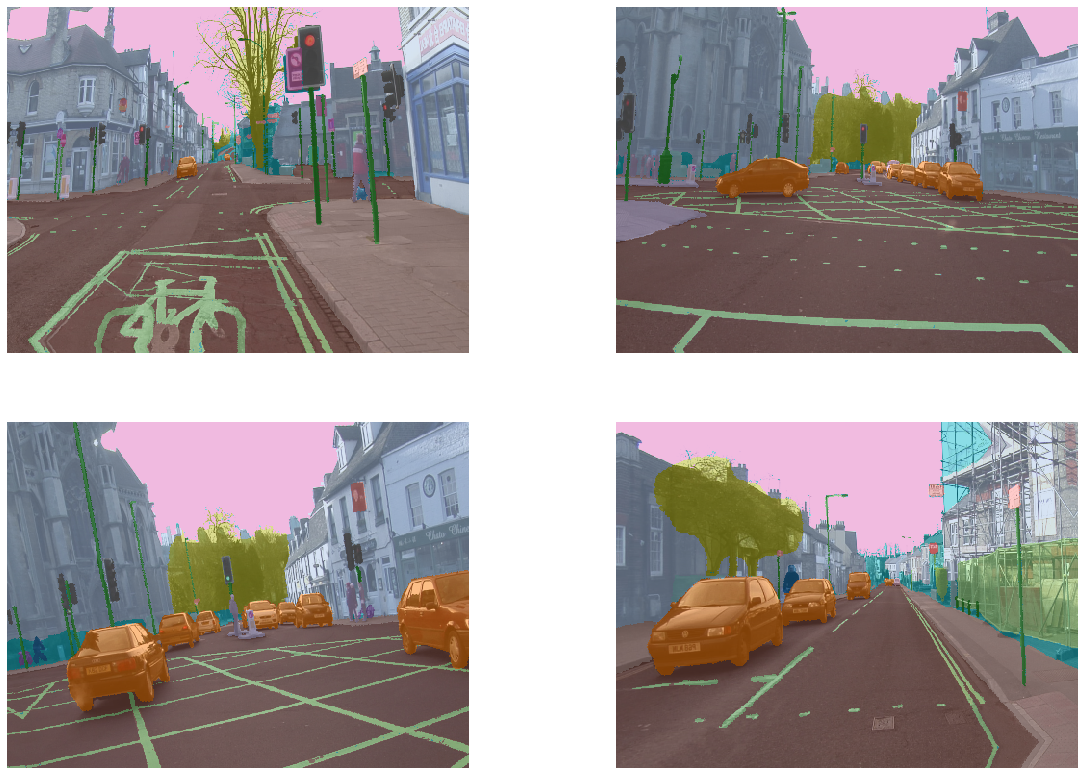

In [ ]:
dls.show_batch(max_n=4, figsize=(20,14))

## Model

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
metrics=acc_camvid
# metrics=accuracy

In [ ]:
wd=1e-2

In [ ]:
dls.vocab = codes

In [ ]:
learn = unet_learner(dls, resnet34, metrics=metrics)

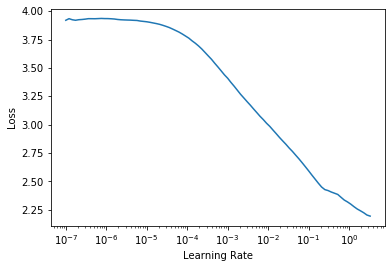

In [ ]:
learn.lr_find()

In [ ]:
lr=3e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9, wd=wd)

epoch,train_loss,valid_loss,acc_camvid,time
0,2.228120,1.750128,0.808884,00:51
1,1.873541,1.638791,0.812702,00:38
2,1.619835,1.414800,0.854545,00:38
3,1.432869,1.426626,0.812345,00:39
4,1.237131,0.991628,0.895642,00:39
5,1.040850,0.934939,0.864443,00:39
6,0.866385,0.657418,0.895164,00:39
7,0.719731,0.533501,0.903053,00:39
8,0.617655,0.496709,0.897753,00:40
9,0.510439,0.371407,0.929200,00:40


In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

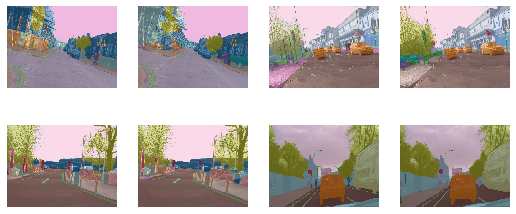

In [ ]:
learn.show_results(max_n=4, figsize=(9,4))

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(12, lrs, pct_start=0.8, wd=wd)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.445669,0.382609,0.925163,00:40
1,0.434895,0.370302,0.928291,00:40
2,0.424628,0.374690,0.923414,00:41
3,0.413396,0.353807,0.929213,00:41
4,0.405388,0.353545,0.927892,00:41
5,0.387343,0.359148,0.924618,00:41
6,0.373569,0.342784,0.924215,00:41
7,0.362610,0.327022,0.928412,00:41
8,0.340308,0.337757,0.923681,00:42
9,0.330054,0.355201,0.917659,00:42


In [ ]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
del learn

In [ ]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [ ]:
dls = camvid.dataloaders(path/"images", bs=3, path=path,
                          batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)])

In [ ]:
dls.vocab = codes

In [ ]:
learn = unet_learner(dls, resnet34, metrics=metrics)

In [ ]:
learn.load('stage-2');

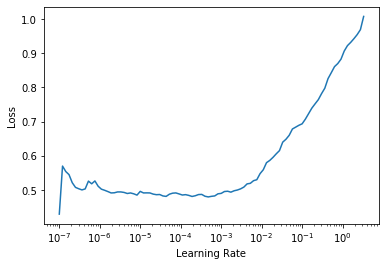

In [ ]:
learn.lr_find()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.434103,0.349006,0.919233,02:28
1,0.416209,0.321492,0.926268,02:27
2,0.374841,0.323334,0.928009,02:30
3,0.373591,0.308711,0.925487,02:30
4,0.354073,0.316937,0.921483,02:29
5,0.333428,0.276603,0.931216,02:28
6,0.343322,0.272028,0.929693,02:28
7,0.313607,0.280513,0.929877,02:28
8,0.278676,0.250869,0.932883,02:29
9,0.236350,0.244575,0.935206,02:28


In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.223516,0.246427,0.936520,02:30
1,0.237247,0.255016,0.935370,02:39
2,0.225134,0.239316,0.936160,02:44
3,0.222252,0.244599,0.936024,02:43
4,0.216221,0.246634,0.935405,02:42
5,0.223981,0.243209,0.935413,02:42
6,0.206087,0.249986,0.934875,02:42
7,0.201352,0.239749,0.936708,02:41
8,0.201420,0.243662,0.936199,02:41
9,0.201602,0.244807,0.936131,02:41


In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

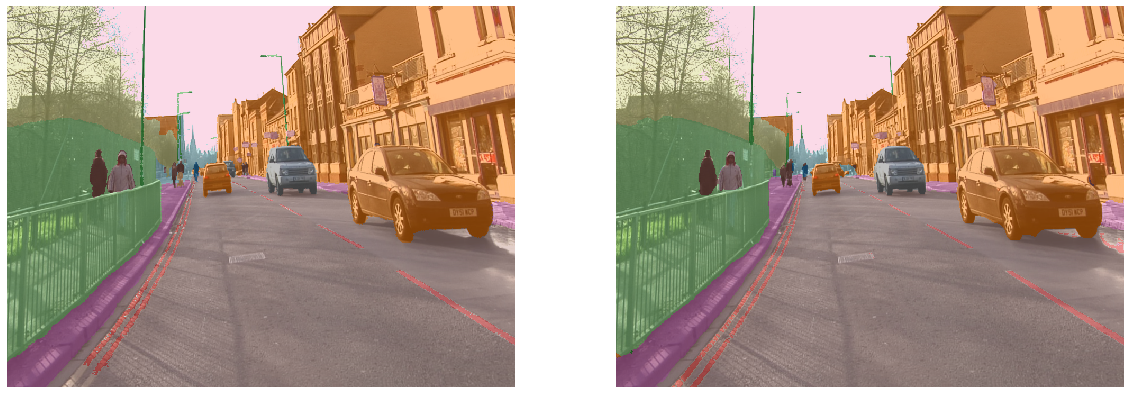

In [ ]:
learn.show_results(max_n=1, figsize=(20,10), vmin=1, vmax=30)

## fin